# Detección de barras en galaxias - Preprocesamiento de imágenes
## Proyecto integrador MNA

### Integrantes
- Jonathan Jesús Marmolejo Hernández - A01795195
- Isaid Posadas Oropeza - A01795015
- Luis Daniel Ortega Muñoz - A01795197

## Introducción

En este ejercicio se explorarán diferentes técnicas de procesamiento de imágenes, con la intención de definir un "pipeline" de preprocesamiento que será aplicado a las imágenes del dataset que ayude a resaltar las estructuras de barras encontradas en las imágenes.

Para efectos de este ejercicio, las técnicas de procesamiento de imágenes serán evaluadas de forma cualitativa; es decir, se aplicarán diversas técnicas y se seleccionarán aquellas que mejor resalten las estructuras de barras a simple vista. En etapas posteriores de este proyecto se compararán estas técnicas de forma cuantitativa, al comparar el impacto que estas tienen en el desempeño de un modelo de clasificación de imágenes.

## Importación de librerías y carga del dataset

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from bargal.images.client import GalaxyImageClient
from bargal.models import Observation

In [2]:
df = pd.read_csv("../data/dataset.csv")

La función `get_random_galaxy` nos ayudará a tomar muestras aleatorias de galaxias del dataset para fines demostrativos durante este ejercicio.

In [3]:
def get_random_galaxy(label=None):
    if label is None:
        return df.sample(1).to_dict(orient='records')[0]

    return df[df.Bars == label].sample(1).to_dict(orient='records')[0]

Asímismo, creamos una instancia de `GalaxyImageClient` para gestionar la descarga de imágenes de las galaxias en el dataset. Este cliente funciona como una abstracción del mecanismo de descarga de imágenes, además de gestionar el almacenamiento de imágenes de forma local para evitar descargas innecesarias.

In [4]:
img_client = GalaxyImageClient(storage_path="../data/images")

## Carga de imágenes

En el [notebook anterior](https://github.com/ludanortmun/itesm-mna-barred-galaxies/blob/main/notebooks/Avance1.Equipo22.ipynb) exploramos las imágenes del dataset, incluyendo las imágenes RGB así como las imágenes en bandas individuales (G, R y Z). 

Con la finalidad de agilizar el manejo de las observaciones de galaxias en diferentes bandas, se creó la clase `Observation`, que encapsula la representación de la galaxia en imágenes RGB y en bandas individuales. La representación RGB es obtenida directamente de la fuente de datos original sin ninguna modificación. Las imágenes en bandas individuales se obtienen también de la fuente de datos, pero son transformadas a escala de grises. Esto es debido a que estas imágenes representan solamente una banda de luz, por lo que no tienen sentido en color. 

Cabe destacar que cada una de estas imágenes en la clase `Observation` están representadas en forma de arreglos multidimensionales; para el caso de la representación RGB se tiene un arreglo de 3 dimensiones, mientras que las imágenes en bandas individuales son representadas como arreglos de 2 dimensiones.

Además de lo anterior, el cliente `GalaxyImageClient` ha sido actualizado para cargar imágenes en forma de objetos de la clase `Observation`.

### Imágenes JPG

Utilizando el parámetro `use_fits=False` en el cliente de imágenes, se pueden descargar imágenes en formato JPG. Este formato es más ligero y permite una visualización más rápida de las imágenes, pero no contiene la información de la imagen original en formato FITS.

In [5]:
g = get_random_galaxy(label=1)
observation = img_client.get_as_observation(g, save_to_disk=True, use_fits=False)

print("RGB image shape:", observation.rgb_repr.shape)
print("G image shape:", observation.g_band.shape)
print("R image shape:", observation.r_band.shape)
print("Z image shape:", observation.z_band.shape)

print("RGB image dtype:", observation.rgb_repr.dtype)
print("G image dtype:", observation.g_band.dtype)
print("R image dtype:", observation.r_band.dtype)
print("Z image dtype:", observation.z_band.dtype)

RGB image shape: (800, 800, 3)
G image shape: (800, 800)
R image shape: (800, 800)
Z image shape: (800, 800)
RGB image dtype: uint8
G image dtype: uint8
R image dtype: uint8
Z image dtype: uint8


La siguiente función puede utilizarse para visualizar lado a lado las imágenes de una galaxia en sus diferentes representaciones.

In [6]:
def display_observation(o: Observation):
    fig, axs = plt.subplots(1, 4, figsize=(20, 5))

    axs[0].imshow(o.rgb_repr)
    axs[0].set_title("RGB")

    axs[1].imshow(o.g_band, cmap="gray")
    axs[1].set_title("G")

    axs[2].imshow(o.r_band, cmap="gray")
    axs[2].set_title("R")

    axs[3].imshow(o.z_band, cmap="gray")
    axs[3].set_title("Z")

    for ax in axs:
        ax.axis("off")
    plt.show()

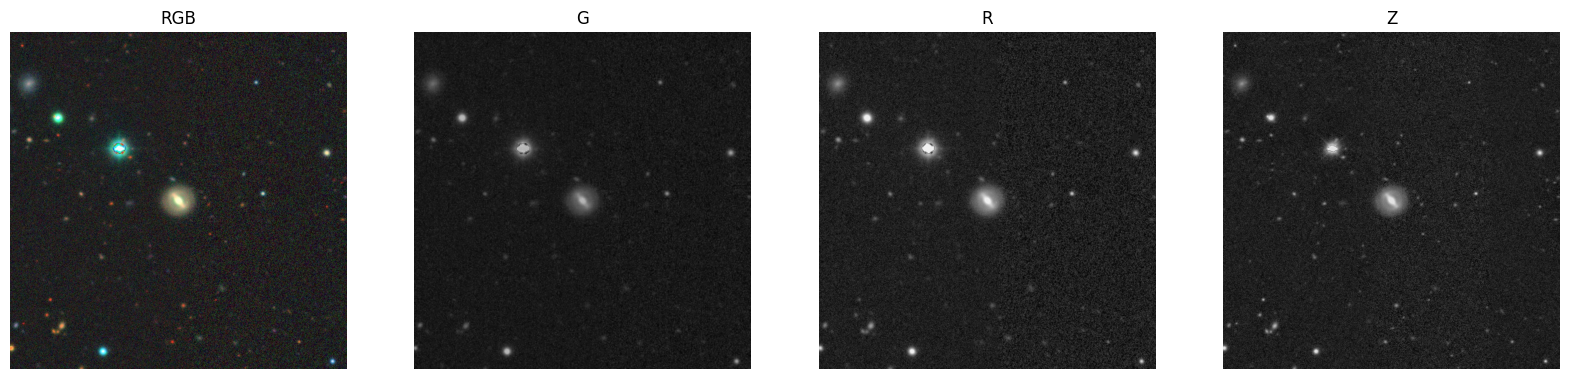

In [7]:
display_observation(observation)

### Preprocesamiento de imágenes JPG


In [8]:
# Librerías a utilizar en esta sección
import cv2
from sklearn.decomposition import PCA

In [12]:
# Importar imagen y aplicación de filtro en gris
imagen_color = observation.rgb_repr
imagen_gris = cv2.cvtColor(observation.rgb_repr, cv2.COLOR_BGR2GRAY)

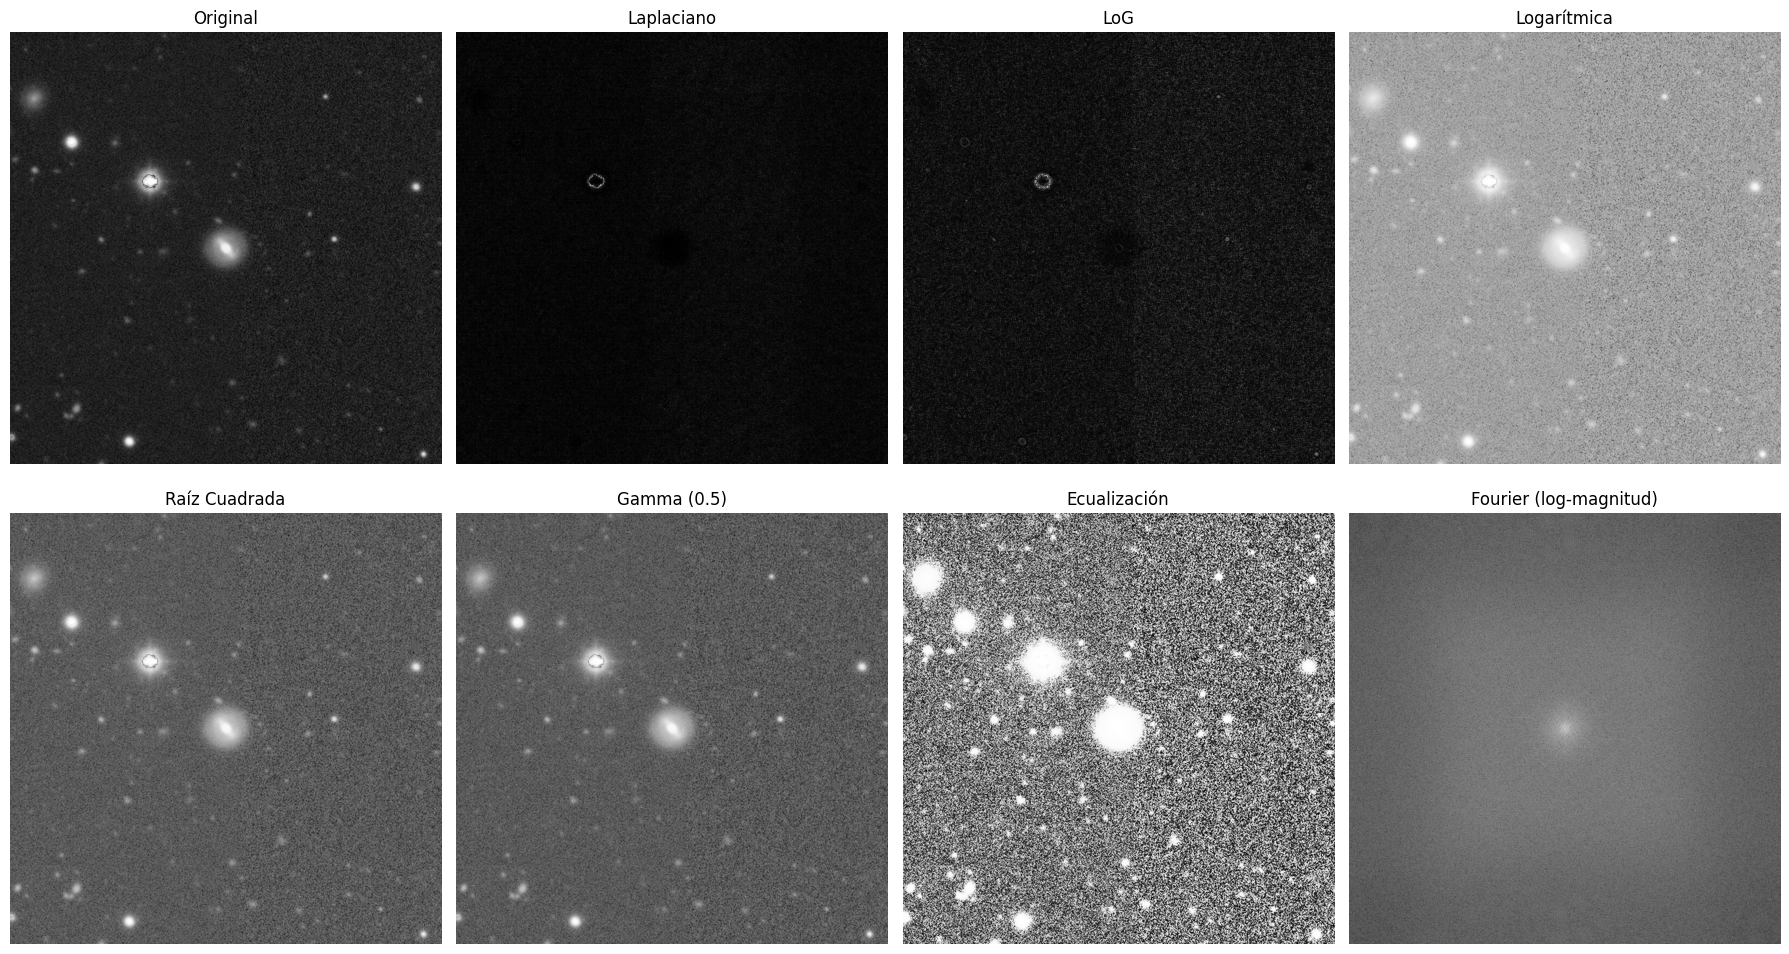

In [13]:
# Aplicación de transformaciones base sobre la imagen importada

def aplicar_transformaciones(img_gray):
    laplaciano = cv2.Laplacian(img_gray, cv2.CV_64F)
    gaussian = cv2.GaussianBlur(img_gray, (5, 5), 0)
    log = cv2.Laplacian(gaussian, cv2.CV_64F)
    log_transform = np.log1p(img_gray.astype(np.float32))
    sqrt_transform = np.sqrt(img_gray.astype(np.float32))
    gamma = np.power(img_gray / 255.0, 0.5) * 255.0
    hist_eq = cv2.equalizeHist(img_gray)
    f = np.fft.fft2(img_gray)
    fshift = np.fft.fftshift(f)
    fourier_mag = 20 * np.log1p(np.abs(fshift))

    return [
        ("Original", img_gray),
        ("Laplaciano", laplaciano),
        ("LoG", log),
        ("Logarítmica", log_transform),
        ("Raíz Cuadrada", sqrt_transform),
        ("Gamma (0.5)", gamma),
        ("Ecualización", hist_eq),
        ("Fourier (log-magnitud)", fourier_mag)
    ]

resultados = aplicar_transformaciones(imagen_gris)

plt.figure(figsize=(18, 10))
for i, (nombre, resultado) in enumerate(resultados):
    plt.subplot(2, 4, i+1)
    plt.imshow(np.abs(resultado), cmap='gray')
    plt.title(nombre)
    plt.axis('off')
plt.tight_layout()
plt.show()

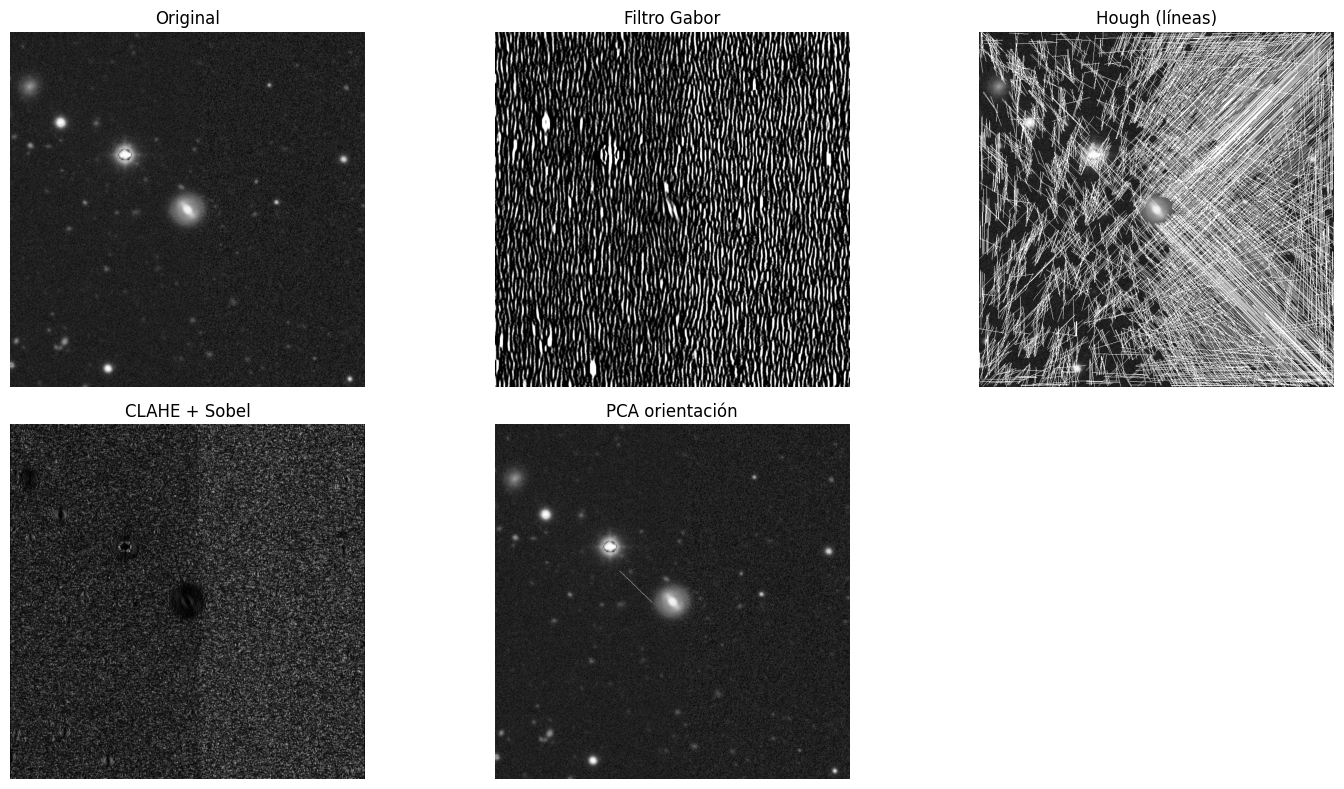

In [14]:
# Aplicación de 4 transformadas extra

def aplicar_transformaciones2(img_color):

    # Convertir a escala de grises
    gray = cv2.cvtColor(img_color, cv2.COLOR_BGR2GRAY)
    # 1. Filtro de Gabor (orientación 0 radianes)
    gabor_kernel = cv2.getGaborKernel((21, 21), sigma=5.0, theta=0, lambd=10.0, gamma=0.5, psi=0)
    gabor_result = cv2.filter2D(gray, cv2.CV_8UC3, gabor_kernel)

    # 2. Transformada de Hough (con Canny + líneas)
    edges = cv2.Canny(gray, 50, 150)
    hough_img = gray.copy()
    lines = cv2.HoughLinesP(edges, 1, np.pi / 180, threshold=100, minLineLength=30, maxLineGap=10)
    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line[0]
            cv2.line(hough_img, (x1, y1), (x2, y2), (255), 1)

    # 3. CLAHE + Sobel horizontal
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    clahe_img = clahe.apply(gray)
    sobel_x = cv2.Sobel(clahe_img, cv2.CV_64F, 1, 0, ksize=5)
    sobel_result = np.abs(sobel_x)

    # 4. PCA sobre píxeles brillantes
    coords = np.column_stack(np.where(gray > 130))
    pca_img = gray.copy()
    if len(coords) > 0:
        pca = PCA(n_components=2)
        pca.fit(coords)
        center = np.mean(coords, axis=0).astype(int)
        vec = pca.components_[0] * 50
        pt1 = tuple(np.round(center - vec).astype(int))
        pt2 = tuple(np.round(center + vec).astype(int))
        cv2.line(pca_img, pt1[::-1], pt2[::-1], 255, 1)

    # Mostrar resultados
    titles = ["Original", "Filtro Gabor", "Hough (líneas)", "CLAHE + Sobel", "PCA orientación"]
    images = [gray, gabor_result, hough_img, sobel_result, pca_img]

    plt.figure(figsize=(15, 8))
    for i in range(5):
        plt.subplot(2, 3, i+1)
        plt.imshow(images[i], cmap='gray')
        plt.title(titles[i])
        plt.axis('off')
    plt.tight_layout()
    plt.show()

aplicar_transformaciones2(imagen_color)

## COMENTARIOS:
- **Transformación logaritmo:** Aumenta el contraste en áreas oscuras y comprime intensidades altas.
- **Operador Laplaciano:** Resalta bordes y detalles de alta frecuencia espacial.
- **Laplaciano del Gaussiano:** Suaviza primero para evitar ruido y luego detecta bordes.
- **Ecuación del histograma:** Redistribuye intensidades para maximizar contraste. A veces puede amplificar el ruido.
- **Gamma:** Potencia visualmente regiones poco iluminadas (corrección gamma clásica).
- **Raiz cuadrada:** Similar a log, mejora visibilidad de zonas oscuras.
- **Transformada de Fourier:** Representa contenido en el dominio de la frecuencia. Permite filtrar por bandas o detectar simetrías espectrales.
- **Filtro Gabor:** Destacta estructuras repetitivas verticales.
- **Hough:** Detecta algunas líneas, pero requiere sintonizar mejor el umbral para resaltar la barra (bajo ruido).
- **Clahe + Sobel:** Realza bordes horizontales en regiones centrales tras mejorar contraste local.
- **PCA Orientación:** Traza una línea con la orientación principal de la galaxia.

**Desde mi perspectiva la función logarítmica y la raíz cuadrada fueron las que mejor destacan la imagen.**

### Imágenes FITS

Por otra parte, si se desea trabajar con imágenes en formato FITS, se puede utilizar el parámetro `use_fits=True` en el cliente de imágenes. Este formato contiene la información en crudo de la imágen astronómica. Esto significa que obtenemos la mayor cantidad de información posible de la imagen, pero estas imágenes requieren de un preprocesamiento adicional para ser visualizadas.

A continuación se carga la observación de la misma galaxia utilizando el formato FITS. Nótese que las imágenes cargadas de esta forma se representan mediante una matriz de `float32` (representadas con el tipo `>f4`; este representa un float de 4 bytes utilizando codificación big endian), mientras que las imágenes JPG son representadas como matrices de `uint8`. También cabe destacar que el formato FITS solo se aplica a las imágenes en bandas individuales; la representación RGB permanece sin cambios.

In [8]:
observation_fits = img_client.get_as_observation(g, save_to_disk=True, use_fits=True)

print("RGB image shape:", observation_fits.rgb_repr.shape)
print("G image shape:", observation_fits.g_band.shape)
print("R image shape:", observation_fits.r_band.shape)
print("Z image shape:", observation_fits.z_band.shape)

print("RGB image dtype:", observation_fits.rgb_repr.dtype)
print("G image dtype:", observation_fits.g_band.dtype)
print("R image dtype:", observation_fits.r_band.dtype)
print("Z image dtype:", observation_fits.z_band.dtype)

RGB image shape: (800, 800, 3)
G image shape: (800, 800)
R image shape: (800, 800)
Z image shape: (800, 800)
RGB image dtype: uint8
G image dtype: >f4
R image dtype: >f4
Z image dtype: >f4


A continuación se visualizan las observaciones de la galaxia en formato FITS. Se puede observar que las imágenes de bandas individuales son mucho más oscuras que sus contrapartes en formato JPG.

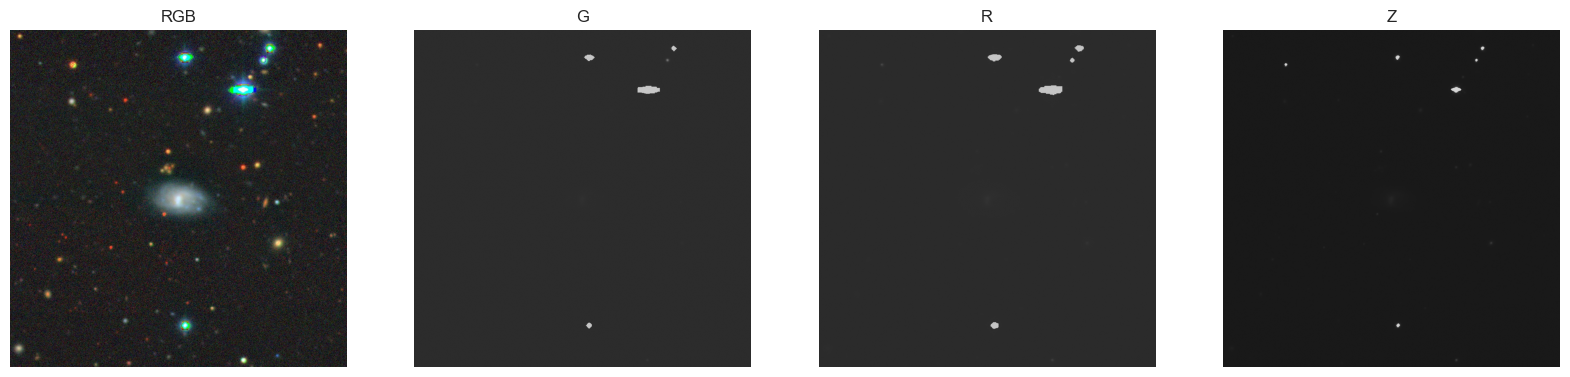

In [9]:
display_observation(observation_fits)

### Preprocesamiento de imágenes FITS